In [11]:
import pandas as pd

In [31]:
diamonds_train = pd.read_csv("../data/diamonds-train.csv")
diamonds_test = pd.read_csv("../data/diamonds-test.csv")

# Inspecting the data

Our goal is to build a simple regressor that can estimate the price of a diamond given a set of characteristics. We use a precompiled dataset with 9 feature columns and a price column. 
We start by inspecting what features we have available to us.

About the data

- price price in US dollars (326--18,823)
- carat weight of the diamond (0.2--5.01)
- cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color diamond colour, from J (worst) to D (best)
- clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- x length in mm (0--10.74)
- y width in mm (0--58.9)
- z depth in mm (0--31.8)
- depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
- table width of top of diamond relative to widest point (43--95)

# Visualize the Data
Just for fun we can visualize the data to see how it looks.

In [6]:
# Allows us to render png images with plotly so we can view it in GitHub
!pip install -U kaleido
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 7.4 MB/s eta 0:00:0000:0100:01
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)


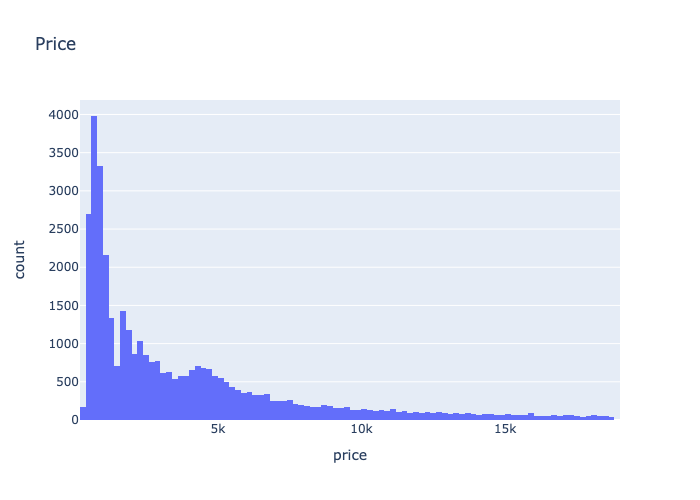

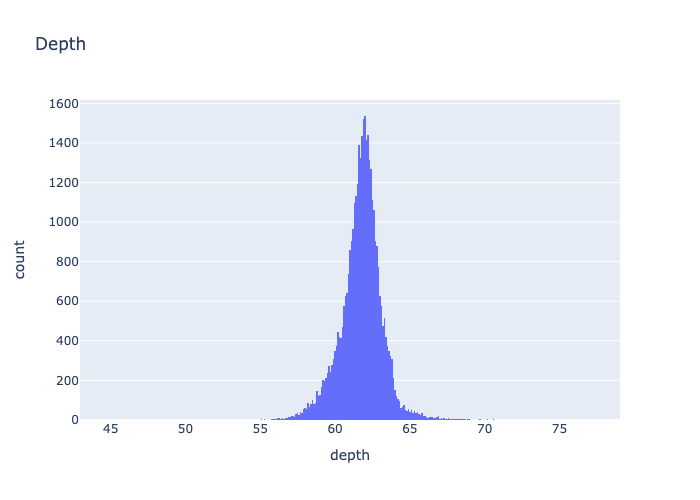

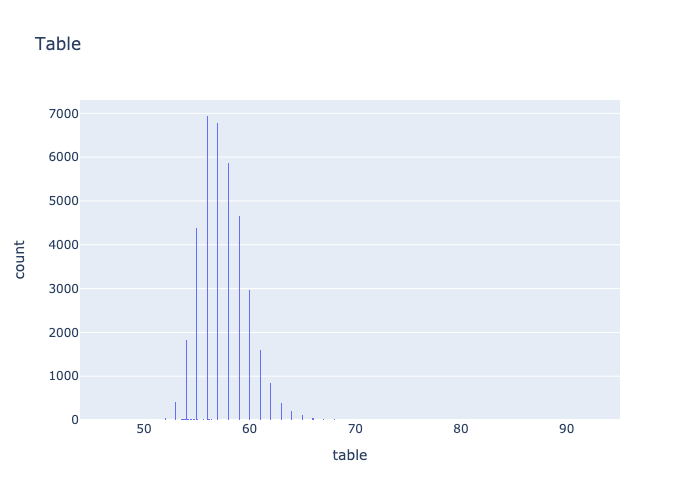

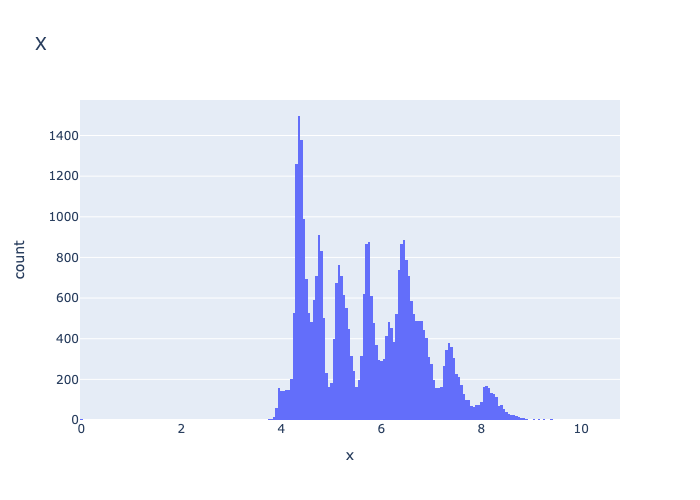

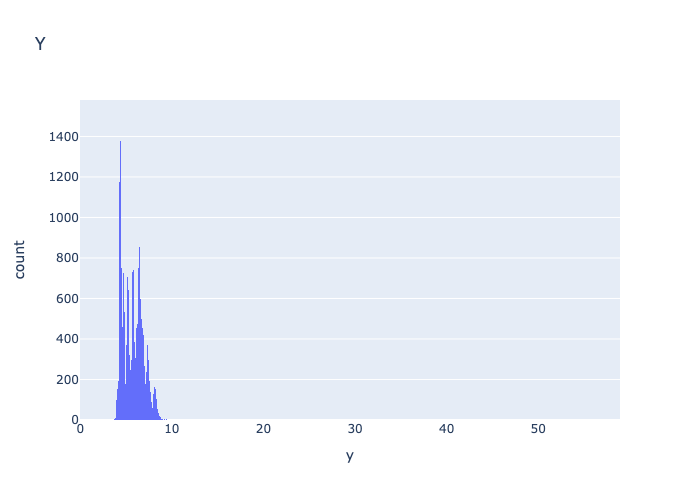

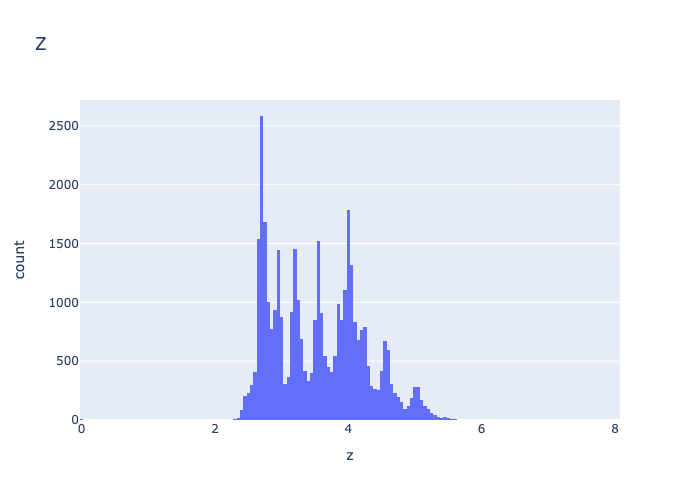

In [13]:
import plotly.express as px

px.histogram(diamonds_train, x='price', title="Price").show("png")
px.histogram(diamonds_train, x='depth', title="Depth").show("png")
px.histogram(diamonds_train, x='table', title="Table").show("png")
px.histogram(diamonds_train, x='x', title="X").show("png")
px.histogram(diamonds_train, x='y', title="Y").show("png")
px.histogram(diamonds_train, x='z', title="Z").show("png")

## Features relation to price
We  suspect that the carat of the diamond, e.g., its size, is closely related to the price. We can try to confirm this hypothesis via a scatter plot.

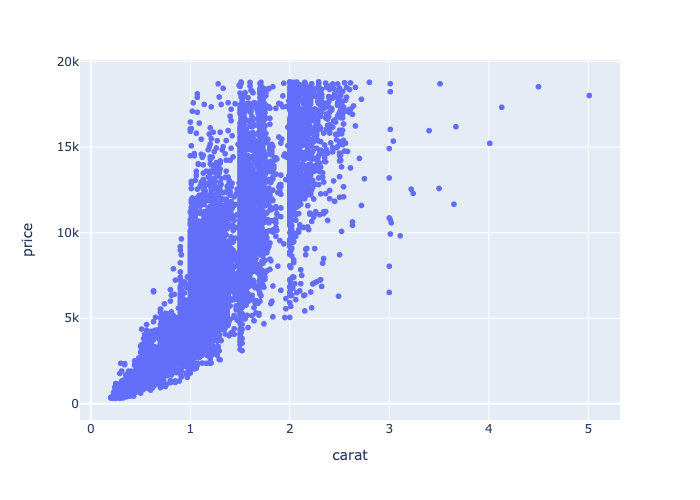

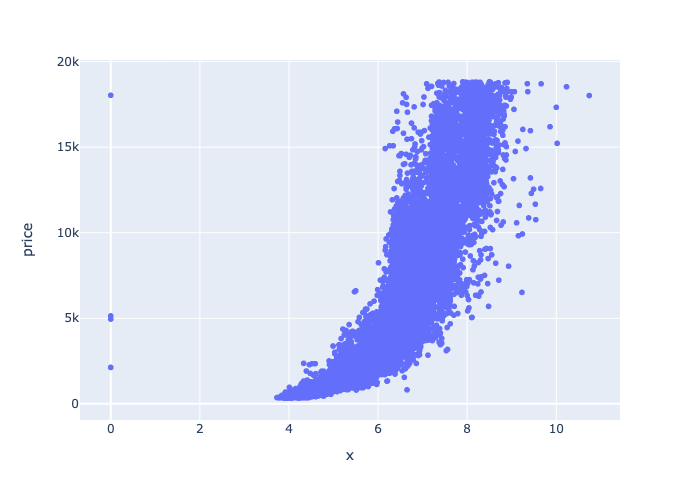

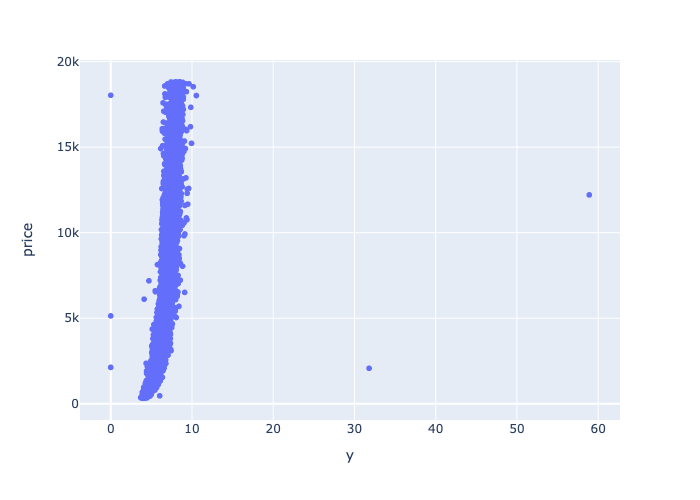

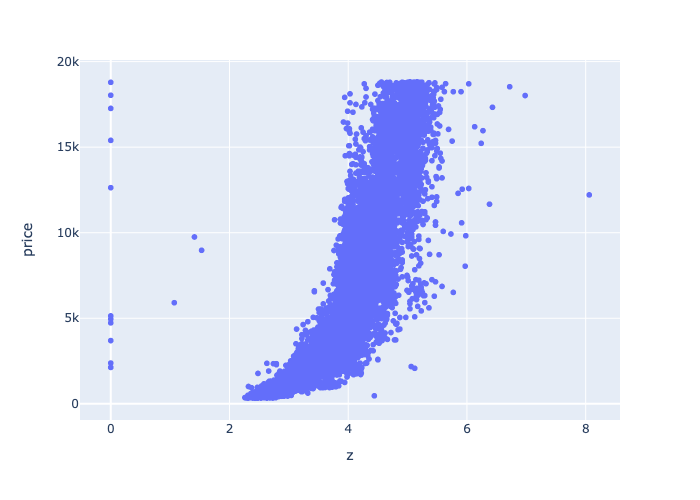

In [14]:
px.scatter(diamonds_train, x='carat', y='price').show("png")
px.scatter(diamonds_train, x='x', y='price').show("png")
px.scatter(diamonds_train, x='y', y='price').show("png")
px.scatter(diamonds_train, x='z', y='price').show("png")

# Relation between categorical columns and price
We can try to see if there is some distinct groups of diamonds if we visualize the price, carat and some of the categorial features.
We can see that clarity har a stark correlation between price, where two equally sized diamonds can have significantly higher price if it is a VS1 rather than SI1.

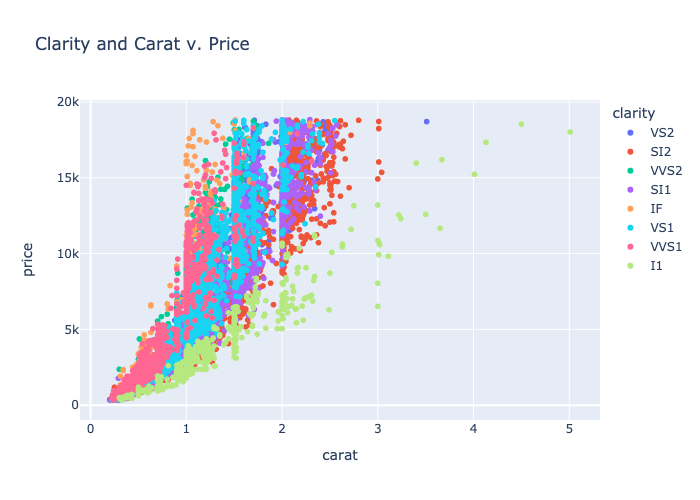

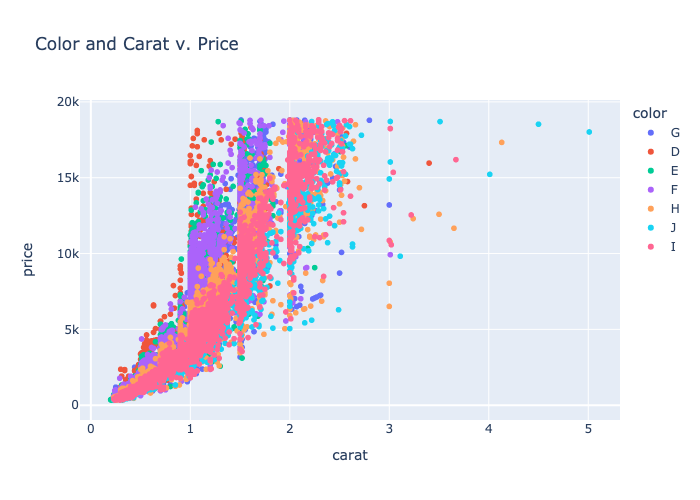

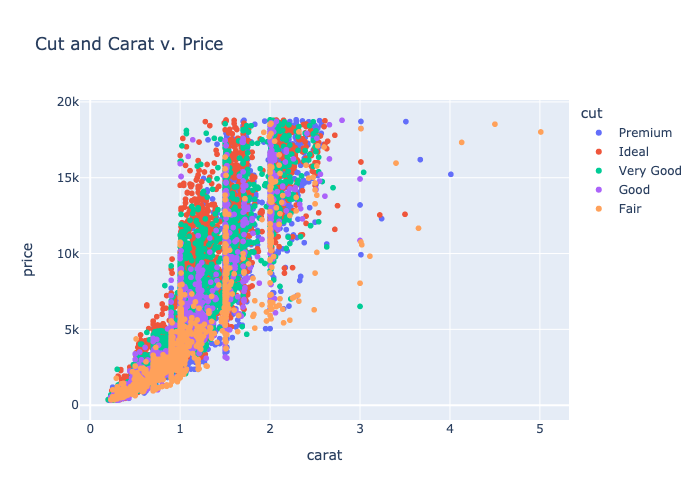

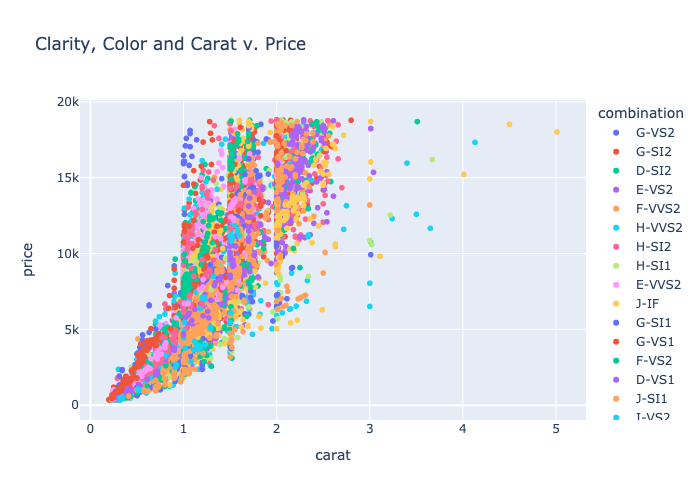

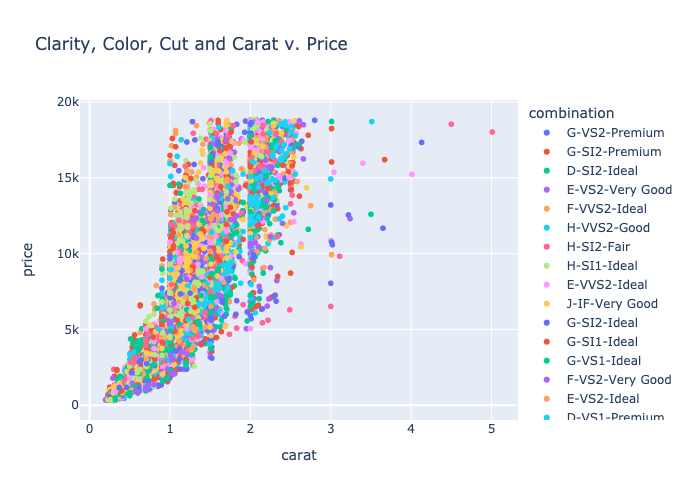

In [16]:
px.scatter(diamonds_train, x='carat', y='price', color='clarity', title="Clarity and Carat v. Price").show("png")
px.scatter(diamonds_train, x='carat', y='price', color='color', title="Color and Carat v. Price").show("png")
px.scatter(diamonds_train, x='carat', y='price', color='cut', title="Cut and Carat v. Price").show("png")

df_test = diamonds_train.copy()
df_test['combination'] = df_test.apply(lambda row: f"{row['color']}-{row['clarity']}", axis=1)
px.scatter(df_test, x='carat', y='price', color='combination', title="Clarity, Color and Carat v. Price").show("png")

df_test = diamonds_train.copy()
df_test['combination'] = df_test.apply(lambda row: f"{row['color']}-{row['clarity']}-{row['cut']}", axis=1)
px.scatter(df_test, x='carat', y='price', color='combination', title="Clarity, Color, Cut and Carat v. Price").show("png")

We can also plot some of the aggregate information of the clarity. Since larger diamonds are less likely to have the more expensive types of clarity, we note that the type of clarity with the highest median price is actually not the most expensive one.

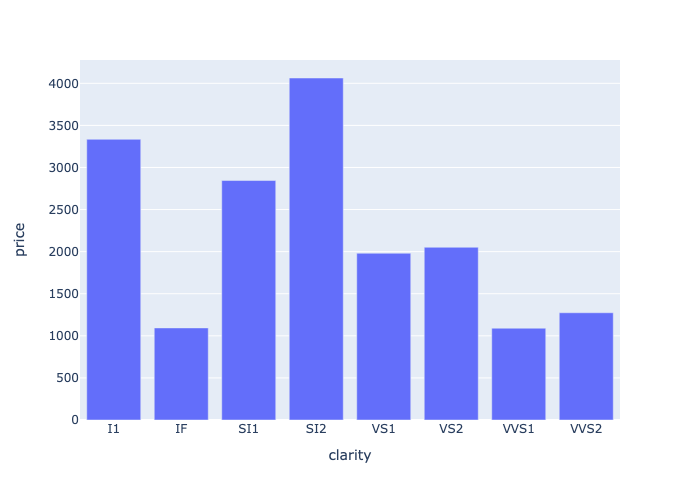

In [17]:
px.bar(diamonds_train.groupby('clarity')['price'].median().reset_index(), x='clarity', y='price').show("png")

# Training a regressor
We start by using a Linear Regression due to it's simplicity. We use a MinAbsScaler to scale our numerical features since we don't want to loose sparsity in the data.

# Data Cleaning
We remove instances that have a diamond dimension of zero. We also remove all rows with a NaN value it.

In [20]:
def clean_dataframe(df):
    df = df.copy()

    # Filter out the zero values we observed before
    df = df[~((df['x'] == 0) | (df['y'] == 0) | (df['z'] == 0))]
    df = df.dropna()
    return df

In [33]:
from sklearn.model_selection import train_test_split
df_train = clean_dataframe(diamonds_train)
df_test = clean_dataframe(diamonds_test)
print("Size of the training set", len(df_train))
print("Size of the test set", len(df_test))

Size of the training set 37703
Size of the test set 13479


In [36]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import joblib

In [37]:
def prepare_data(df):
    df = df.copy()
    y = df.pop('price')
    return df, y

In [39]:
regressor = LinearRegression()
ct = make_column_transformer(
    (MaxAbsScaler(), make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(), make_column_selector(dtype_include=object)),
)

X_train, y_train = prepare_data(df_train)
X_test, y_test = prepare_data(df_test)

model = Pipeline([("ColumnTransformer", ct), ("Regressor", regressor)])
model.fit(X_train, y_train)
y_ = model.predict(X_test)

rmse = mean_squared_error(y_test, y_, squared=False)
r2 = r2_score(y_test, y_)
print("rmse", rmse)
print("r2", r2)

rmse 1147.8441361600371
r2 0.9182446335506089


In [40]:
from pathlib import Path
import joblib

path = Path("outputs", "model.pkl")
path.parent.mkdir(exist_ok=True)
joblib.dump(model, filename=str(path))

['outputs/model.pkl']